### Research Question

Media plays a crucial role in shaping public perception, yet different news sources often frame the same event in varied ways, reflecting ideological biases. This study seeks to explore the extent to which media sources differ in their framing of news and how machine learning can be used to categorize statements by their ideological alignment. By leveraging natural language processing (NLP) techniques and machine learning models, this research aims to classify news articles based on ideological bias—left, neutral, or right—thus contributing to the broader discourse on media objectivity and automated content analysis.

Previous research has demonstrated the effectiveness of machine learning techniques in identifying media bias and political ideology in news articles. Several key studies provide a strong foundation for this investigation:

Fiore (2019) explores the automatic identification of political ideology in online news, highlighting that machine learning classifiers can outperform human annotators in categorizing ideological leanings. The study underscores the potential of text-based features such as word usage, sentiment, and topic modeling in detecting political bias, reinforcing the feasibility of automated classification techniques.

Chao et al. (2022) apply bidirectional Long Short-Term Memory (BiLSTM) neural networks to analyze media bias and content quality. Their findings suggest that deep learning models, particularly those leveraging contextual embedding methods such as word2vec, BERT, and LLaMA, significantly improve classification performance by capturing nuanced semantic differences in political discourse.

Martín-Forero et al. (2022) examine traditional machine learning approaches, including Random Forest and Logistic Regression, for political ideology detection. Their study finds that these models perform competitively, even without deep learning, suggesting that ensemble learning techniques—such as boosting and stacking—can further enhance classification accuracy. Additionally, the research highlights the importance of feature engineering, including source credibility and citation patterns, in improving model interpretability.

Research Question:

To what extent do media sources differ in their framing of news, and how can machine learning be used to categorize statements by their ideological alignment?

Task Type: Multi-Class Classification

The problem of identifying ideological bias in news content can be framed as a multi-class classification task, where statements are categorized into three distinct ideological groups:
	•	Left (Liberal/Progressive)
	•	Neutral (Centrist, Objective)
	•	Right (Conservative)

This is a supervised learning problem, where models are trained on labeled datasets containing news articles with known ideological orientations.

Machine Learning Models for Evaluation

To determine the most effective approach, a combination of traditional, deep learning, and ensemble models will be evaluated:

Baseline Models (Traditional Machine Learning)
	•	Random Forest: A tree-based model capable of capturing feature interactions.
	•	Logistic Regression: A simple, interpretable model for analyzing word impact.

Deep Learning Models (Advanced NLP)
	•	LLaMA (Large Language Model Meta AI): A state-of-the-art transformer-based model known for its accuracy in NLP tasks.
	•	Bidirectional LSTM (BiLSTM): A recurrent neural network model that effectively captures contextual dependencies in political language.

Ensemble and Boosting Methods
	•	Boosting (XGBoost, AdaBoost, LightGBM): Techniques that iteratively refine weak classifiers for improved performance.
	•	Stacking (Hybrid Model): Combining multiple models (e.g., blending Random Forest, LLaMA, and BiLSTM) to enhance classification accuracy.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
import os
import json

### Load in the data

In [3]:
df = pd.read_csv('data/data_random_split.csv')

In [30]:
df.head()
df.shape

(36274, 15)

- Our news article data were crawled from Allsides.com, a news conglomerate platform featuring news reporting from the spectrum of political bias. From the website, we obtained manual labels by experts on each news article's text-level political bias as our outcome variable and ground truth.
- In total, we obtained 36,274 news pieces with 15 columns of features relevant to the pieces. However, our interest mainly lies on the text itself, namely, the "content_original" column.
- The dataset has been applied to machine learning tasks and with labels on the train-test-validation status. Our analysis follows its original assignement. The distribution of splits are shown below.

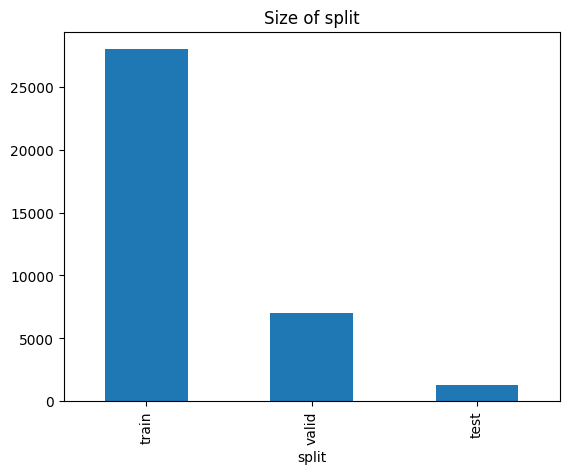

In [56]:
df['split'].value_counts().plot(kind='bar', title="Size of split")
plt.show()

The dataset has already been cleaned and preprocessed as in the content column.

In [5]:
df.columns

Index(['topic', 'source', 'bias', 'url', 'title', 'date', 'authors', 'content',
       'content_original', 'source_url', 'bias_text', 'ID', 'split'],
      dtype='object')

In [6]:
#check missing values in the dataset
df.isnull().sum()

topic                  0
source                 0
bias                   0
url                    0
title                  0
date                4039
authors             9262
content                0
content_original       0
source_url             0
bias_text              0
ID                     0
split                  0
dtype: int64

### Example News Articles for Demonstration

In [ ]:
# randomly select 1 news article from the dataset
pd.set_option('display.max_colwidth', None)
df.sample(1).loc[:,'content_original']

18846    Coca-Cola is eyeing the cannabis market, according to a Monday Bloomberg report.\n\nWhat is Coca-Cola doing?\n\nThe company is interested in cannabidiol oil in particular, one of two primary marijuana molecules. Cannabidiol — or CBD — is not a mind-altering or psychoactive substance, while its relative, tetrahydrocannabinol — or THC — is.\n\nThe company is reportedly watching the cannabis industry and is intrigued by the idea of drinks infused with CBD.\n\nThe company is reportedly intrigued enough that they are in what are reported to be "serious talks" with Canadian marijuana producer, Aurora Cannabis, Inc., according to Canada's BNN Bloomberg Television.\n\nCoca-Cola Co. spokesperson Kent Landers issued a statement on the reports confirming the company's monitoring of CBD.\n\n"We are closely watching the growth of non-psychoactive CBD as an ingredient in functional wellness beverages around the world," Landers said. "The space is evolving quickly. No decisions have been mad

### EDA

The target variable, article political bias has three classes: left (0), center (1), and right (2). The bias distribution is quite balanced in each category. 

In [ ]:
df['bias'].value_counts()

bias
2    13399
0    12590
1    10285
Name: count, dtype: int64

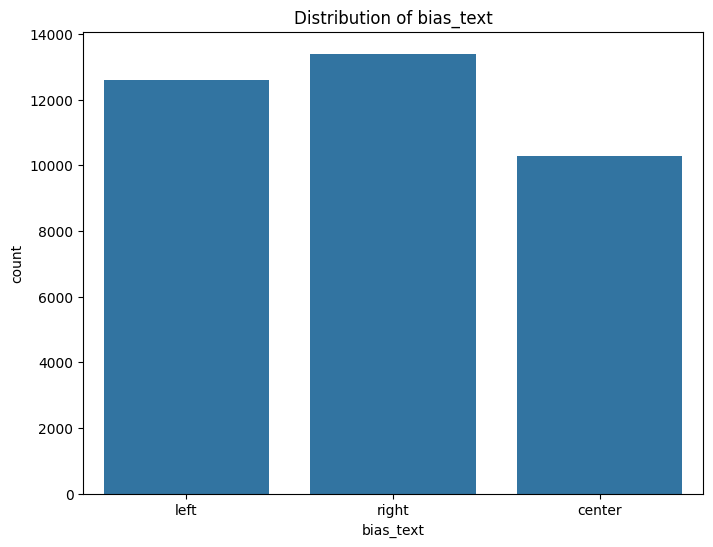

In [7]:
# plot the distribution of bias_text
plt.figure(figsize=(8, 6))
sns.countplot(x='bias_text', data=df)
plt.title('Distribution of bias_text')
plt.show()

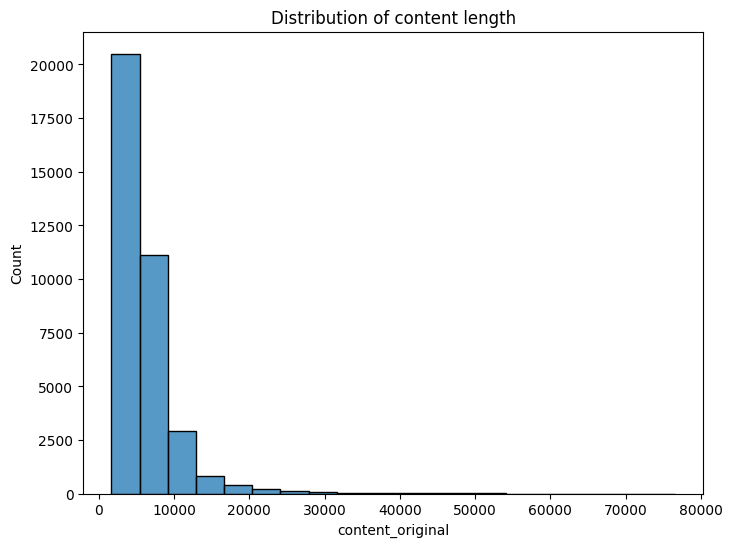

In [39]:
# plot the distribution of content length
plt.figure(figsize=(8, 6))
sns.histplot(df['content_original'].str.len(), bins=20)
plt.title('Distribution of content length')
plt.show()

### Word Clouds for Each Bias

In [7]:
# Remove stopwords
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english')) | set(("said", "s"))

def remove_stopwords(text):
    word_tokens = text.split()
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

df['cloud_text'] = df['content_original'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eddietian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


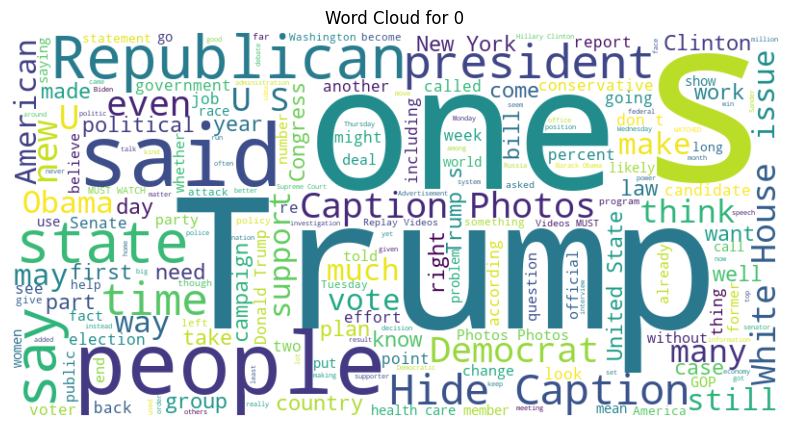

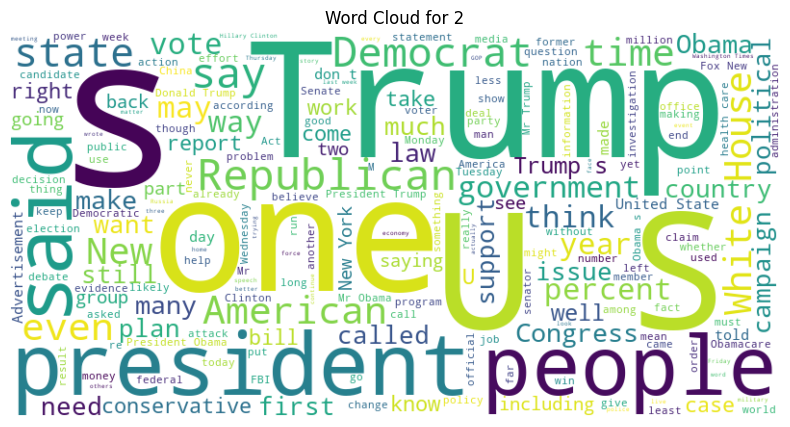

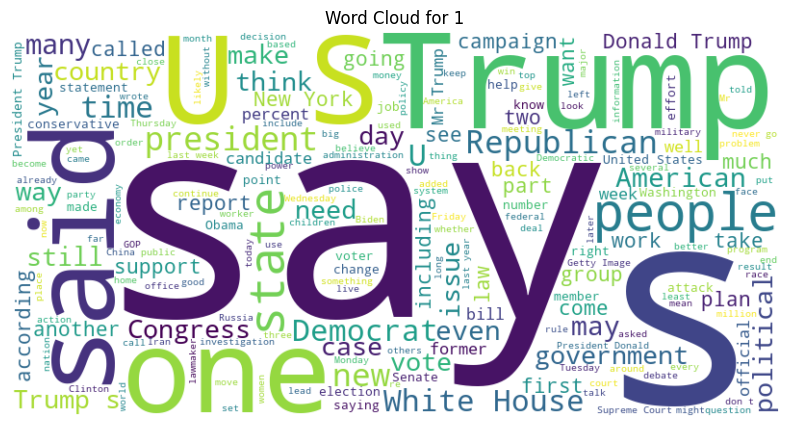

In [10]:
# !pip install wordcloud
from wordcloud import WordCloud

biases = df['bias'].unique()
for bias in biases:
    # Sample 1% of the data
    df_sample = df[df['bias'] == bias].sample(frac=0.1)
    text = ' '.join(df_sample['cloud_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {bias}")
    plt.axis('off')
    plt.show()

### Text Preprocessing

Our input is essentially texts. Preprocessing wise, we experiment with both tfidf with stop words removal, and text embedding by a BERT variant transformer. Since tfidf produces a very larger sparse matrix given the size of our dataset, we restrict the number of features to 3000 for practical reasons. 

Embedding methods, on the other hand, creates a dense representation, thus not suffer from the high dimensionality. But we recognize that BERT-based transformers can only take in a maximum of 512 tokens, while most of our news articles have word count above 5000. Thus, the text embedding may not well capture the semantics and meaning of texts. So, we only used it for experimentation and have the analysis focusing on the tf-idf matrix. 

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from tqdm import tqdm

def tokenize_and_tfidf(df, text_column='content_original'):
    """
    Tokenizes text using a Transformer tokenizer and applies TF-IDF vectorization.

    Parameters:
    - df (pd.DataFrame): DataFrame containing a column with text data.
    - text_column (str): Column name that contains raw text.
    - model_name (str): Hugging Face model to use for tokenization.

    Returns:
    - tfidf_matrix (sparse matrix): TF-IDF transformed matrix of tokenized text.
    - feature_names (list): List of TF-IDF feature names (tokens).
    """

    # Enable progress bar
    tqdm.pandas()

    # Apply TF-IDF and remove stopwords with automatic tokenizer
    tfidf = TfidfVectorizer(stop_words='english', max_features=3000, min_df=5)
    tfidf_matrix = tfidf.fit_transform(df[text_column])

    return tfidf_matrix, tfidf.get_feature_names_out()

In [41]:
# Run Tokenization and TF-IDF
tfidf_matrix, feature_names = tokenize_and_tfidf(df, text_column='content_original')

# Check the shape of the matrix
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

# Display sample feature names (tokens)
print("Sample Tokens:", feature_names[:10])

TF-IDF Matrix Shape: (36274, 3000)
Sample Tokens: ['000' '01' '02' '10' '100' '11' '12' '13' '14' '15']


In [42]:
# convert the matrix to a pandas DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df

,000,01,02,10,100,11,12,13,14,15,...,year,years,yemen,yes,yesterday,york,young,younger,zero,zone
0,0.144946,0.000000,0.000000,0.019017,0.024255,0.0,0.023277,0.026293,0.000000,0.000000,...,0.000000,0.000000,0.0,0.02721,0.0,0.000000,0.000000,0.000000,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.019768,0.042324,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.015402,...,0.000000,0.009236,0.0,0.00000,0.0,0.011844,0.000000,0.000000,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.016886,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0
4,0.000000,0.000000,0.000000,0.040314,0.000000,0.0,0.000000,0.000000,0.000000,0.048563,...,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36269,0.065156,0.000000,0.000000,0.068387,0.043613,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.043549,0.061074,0.0,0.0
36270,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.018258,0.039091,0.0,0.00000,0.0,0.025065,0.000000,0.000000,0.0,0.0
36271,0.000000,0.023077,0.023052,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.008342,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0
36272,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.025665,0.022236,...,0.236656,0.026668,0.0,0.00000,0.0,0.017099,0.000000,0.000000,0.0,0.0


In [45]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# remove numeric tokens in tfidf_df
def remove_numeric_tokens(text):
    return " ".join([word for word in text.split() if not re.fullmatch(r"\d+", word)])

# Apply the function to the 'content' column
df['clean_text'] = df['content_original'].apply(remove_numeric_tokens)

# Run Tokenization and TF-IDF
tfidf_matrix, feature_names = tokenize_and_tfidf(df, text_column='clean_text')

# Check the shape of the matrix
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

TF-IDF Matrix Shape: (36274, 3000)


In [44]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df.head()

,000,01,02,10,100,11,12,13,15,16,...,year,years,yemen,yes,yesterday,york,young,younger,zero,zone
0,0.153855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.02919,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.019867,0.042883,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.010659,0.0,0.00000,0.0,0.013705,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.017621,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075991,0.0,...,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0


### Top N frequent words for each bias

In [ ]:
# For each bias, get the top 10 words by average TF-IDF score
for bias in biases:
    mean_tfidf = tfidf_df[df['bias'] == bias].mean().drop('bias')
    top_words = mean_tfidf.sort_values(ascending=False).head(10)
    print(f"Top words for bias '{bias}':")
    print(top_words, "\n")

Top words for bias '2':
trump        0.064248
said         0.058229
mr           0.049287
president    0.040600
obama        0.037367
house        0.028516
clinton      0.026163
people       0.026068
percent      0.025444
state        0.023815
dtype: float64 

Top words for bias '0':
trump        0.068833
said         0.059145
obama        0.037310
president    0.035066
clinton      0.029868
people       0.029843
house        0.029615
mr           0.028256
campaign     0.025520
new          0.025287
dtype: float64 

Top words for bias '1':
trump        0.090170
said         0.066865
president    0.040208
mr           0.032708
says         0.032327
house        0.032123
people       0.026684
democrats    0.024989
new          0.024437
state        0.024322
dtype: float64 



### SVD-TSNE on TFIDF Matrix & PCA-TSNE on Text Embeddings

In [44]:
# SVD on TF-IDF matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

svd = TruncatedSVD(n_components=30, random_state=42)
tfidf_svd = svd.fit_transform(tfidf_df)

In [45]:
# tsne on SVD reduced tfidf matrix using sns scatter plot
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(tfidf_svd)

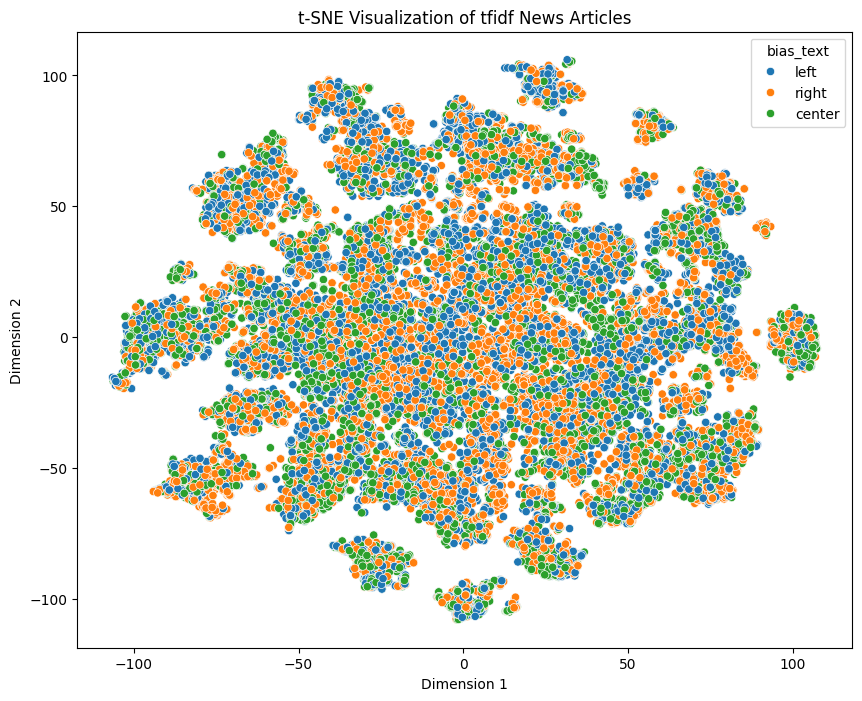

In [46]:
# sns visulization
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=df['bias_text'])
plt.title('t-SNE Visualization of tfidf News Articles')
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [34]:
embeddings = np.load('data/embeddings.npy')
# turn the embeddings into a DataFrame
embeddings_df = pd.DataFrame(embeddings, index=df.index)
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.044637,0.010822,-0.031958,-0.023198,0.035853,-0.009816,0.020184,0.098970,0.022755,0.005069,...,-0.028499,-0.041892,0.004570,-0.058777,0.029095,0.002954,-0.017760,-0.035306,-0.014941,0.008707
1,0.009138,0.020595,-0.046163,-0.017980,0.030119,-0.008256,-0.015530,0.077065,0.026222,-0.034615,...,-0.011678,-0.052556,-0.007108,-0.032771,0.003725,0.031655,0.012347,-0.007065,-0.006181,0.009682
2,0.041385,0.011970,-0.035994,-0.012322,0.022936,-0.024032,-0.036985,0.074083,0.064832,-0.009455,...,-0.045175,-0.014621,-0.020739,-0.035468,0.000400,0.022788,0.006190,-0.038927,-0.042846,0.021215
3,0.025437,0.005591,-0.035518,-0.025949,0.031492,-0.024037,-0.015383,0.076002,0.034206,-0.003800,...,-0.014989,-0.051504,0.011560,-0.025740,0.006034,0.025913,-0.014864,-0.036747,-0.058287,0.015377
4,0.020295,0.021048,-0.039424,-0.001009,0.037378,-0.012874,-0.017437,0.085674,0.029621,-0.001029,...,-0.062306,-0.032559,-0.014998,-0.057534,0.009863,0.015278,-0.003660,-0.032354,-0.042045,0.006480


In [38]:
# PCA on embeddings
from sklearn.decomposition import PCA

pca = PCA(n_components=30, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

In [ ]:
# tsne on PCA reduced embeddings matrix
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings_pca)

In [ ]:
# sns visulization
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=df['bias_text'])
plt.title('t-SNE Visualization of embedded News Articles')
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

NameError: name 'tsne_results' is not defined

## Model Training

### Tree-Based Model

In [13]:
df["split"].value_counts()

split
train    27978
valid     6996
test      1300
Name: count, dtype: int64

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Convert TF-IDF matrix to array
X = tfidf_matrix.toarray()
y = df['bias']

X_train = X[df["split"] == "train"]
y_train = y[df["split"] == "train"]
X_val = X[df["split"] == "valid"]
y_val = y[df["split"] == "valid"]
X_test = X[df["split"] == "test"]
y_test = y[df["split"] == "test"]

In [15]:
print("Training Set Shape:", X_train.shape, y_train.shape)

Training Set Shape: (27978, 3000) (27978,)


In [ ]:
# Train Random Forest model
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

# Predict on test set
y_pred = rf_clf.predict(X_val)

# Evaluate model performance
accuracy = accuracy_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, target_names=['left', 'center', 'right'])

print("Random Forest Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Random Forest Accuracy: 0.6972555746140652
Classification Report:
               precision    recall  f1-score   support

        left       0.76      0.63      0.69      2438
      center       0.83      0.57      0.67      1998
       right       0.61      0.87      0.72      2560

    accuracy                           0.70      6996
   macro avg       0.74      0.69      0.69      6996
weighted avg       0.73      0.70      0.69      6996



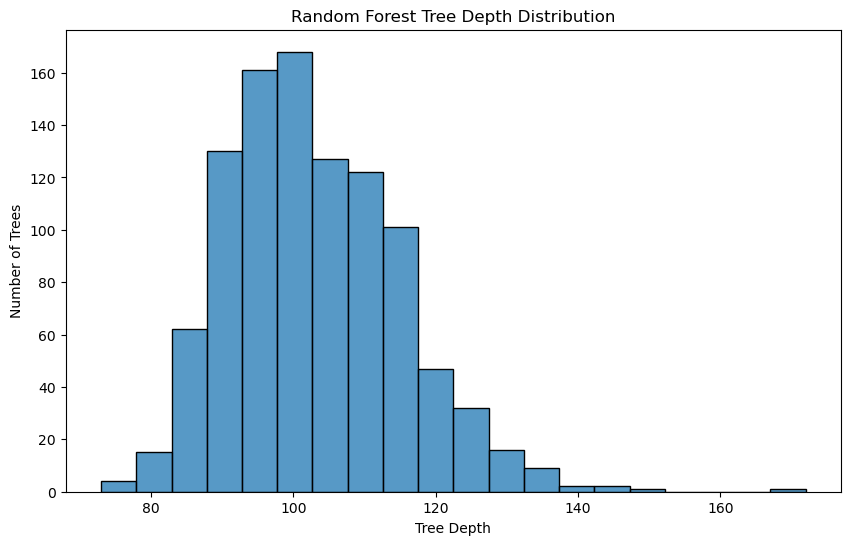

In [ ]:
# Visualize the depth of the trees
plt.figure(figsize=(10, 6))
sns.histplot([estimator.tree_.max_depth for estimator in rf_clf.estimators_], bins=20)
plt.title('Random Forest Tree Depth Distribution')
plt.xlabel('Tree Depth')
plt.ylabel('Number of Trees')
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter for RandomizedSearch
param_grid = {
    'n_estimators': [100, 300, 500, 1000],  # Number of trees
    'max_depth': [30, 50, 100, 125, 150],     # Depth of trees
    'min_samples_split': [2, 5, 10]   # Minimum samples per split
}

# Run RandomizedSearch
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid, cv=3, verbose=2, n_iter=15)
random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)

# Train final model with best params
best_rf = random_search.best_estimator_
y_pred_best = best_rf.predict(X_val)

# Evaluate tuned model
print("Tuned Random Forest Accuracy:", accuracy_score(y_val, y_pred_best))

In [21]:
# rf with best params
best_rf = RandomForestClassifier(n_estimators=1000, min_samples_split=10, max_depth=125, random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_val)
print(classification_report(y_val, y_pred, target_names=['left', 'center', 'right']))

              precision    recall  f1-score   support

        left       0.76      0.64      0.69      2438
      center       0.83      0.57      0.67      1998
       right       0.61      0.86      0.72      2560

    accuracy                           0.70      6996
   macro avg       0.74      0.69      0.70      6996
weighted avg       0.73      0.70      0.70      6996



In [22]:
print(classification_report(y_val, y_pred_best, target_names=['left', 'center', 'right']))

NameError: name 'y_pred_best' is not defined

### PCA

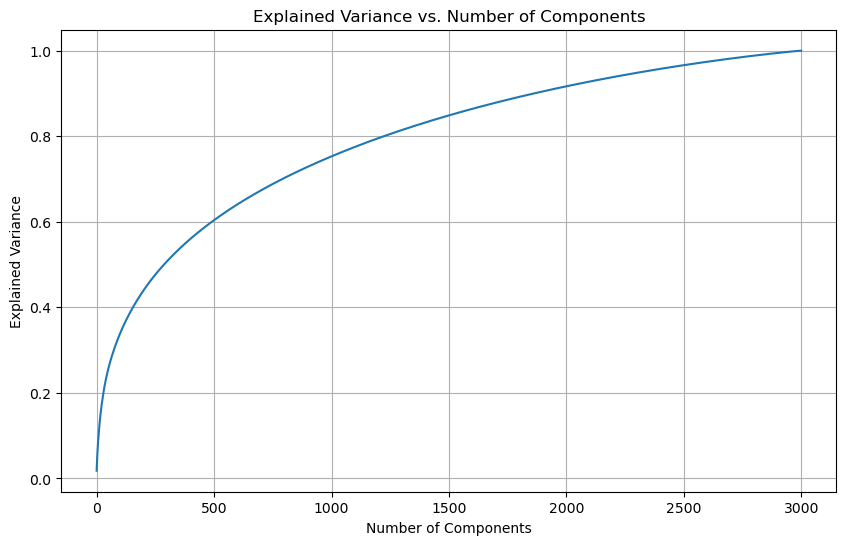

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Initialize PCA with 2 components
pca = PCA(n_components=3000)
X_pca = pca.fit_transform(X)    # Fit and transform the data


# Plot explained variance to find the best n_components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()


In [ ]:
# Apply PCA with optimal components
from sklearn.decomposition import PCA
pca = PCA(n_components=2000)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
# #save pca results
# np.save('X_train_pca.npy', X_train_pca)
# np.save('X_test_pca.npy', X_test_pca)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train Random Forest on PCA-reduced features
rf_clf_pca = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf_clf_pca.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred_pca = rf_clf_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
classification_report_pca = classification_report(y_test, y_pred_pca, target_names=['left', 'center', 'right'])

print("Random Forest Accuracy after PCA:", accuracy_pca)
print("Classification Report:\n", classification_report_pca)

Random Forest Accuracy after PCA: 0.4642524297696711
Classification Report:
               precision    recall  f1-score   support

        left       0.47      0.47      0.47      2629
      center       0.59      0.13      0.21      2103
       right       0.45      0.71      0.55      2779

    accuracy                           0.46      7511
   macro avg       0.50      0.44      0.41      7511
weighted avg       0.50      0.46      0.43      7511



In [ ]:
# logreg on PCA reduced features
from sklearn.linear_model import LogisticRegression
logreg_pca = LogisticRegression(max_iter=1000)
logreg_pca.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred_logreg_pca = logreg_pca.predict(X_test_pca)
accuracy_logreg_pca = accuracy_score(y_test, y_pred_logreg_pca)
classification_report_logreg_pca = classification_report(y_test, y_pred_logreg_pca, target_names=['left', 'center', 'right'])

In [ ]:
print(classification_report_logreg_pca)

              precision    recall  f1-score   support

        left       0.60      0.57      0.59       402
      center       0.58      0.74      0.65       299
       right       0.70      0.62      0.66       599

    accuracy                           0.64      1300
   macro avg       0.63      0.65      0.63      1300
weighted avg       0.64      0.64      0.64      1300



### Model 2: Logistic Regression

In [59]:
# # load in the pca results
# X_train_pca = np.load('X_train_pca.npy')
# X_test_pca = np.load('X_test_pca.npy')

y = df['bias']

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from collections import Counter

In [61]:
y = df['bias']
Counter(y)

Counter({2: 13399, 0: 12590, 1: 10285})

In [63]:
# a baseline logistic regression model
baseline_clf = LogisticRegression(random_state=42, solver="saga", max_iter=1000, n_jobs=-1)
baseline_clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42, solver='saga')

In [64]:
y_pred_baseline = baseline_clf.predict(X_val)

In [65]:
# baseline logreg evaluation
print(classification_report(y_val, y_pred_baseline, target_names=['left', 'center', 'right']))

              precision    recall  f1-score   support

        left       0.69      0.67      0.68      2438
      center       0.70      0.65      0.68      1998
       right       0.66      0.72      0.69      2560

    accuracy                           0.68      6996
   macro avg       0.69      0.68      0.68      6996
weighted avg       0.68      0.68      0.68      6996



We train a logistic regression classifier while randomly searching for the best hyperparameters with 2-fold cross validation. The random search outputs a model that chooses l1 norm, namely LASSO, and penalty 1. 

In [ ]:
# Logistic Regression and hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# random search for best hyperparameters
param_rand = {
    'C': [0.1, 0.5, 1, 10, 100],
    'penalty':('l1', 'l2')
}

rand_search = RandomizedSearchCV(LogisticRegression(random_state=42, solver="saga", max_iter=1000, n_jobs=-1), 
                                 param_rand,cv=2, verbose=2, n_iter=10, n_jobs=-1)
rand_search.fit(X_train, y_train)

print("Best Parameters from Random Search:", rand_search.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END ..................................C=0.1, penalty=l2; total time=  32.1s
[CV] END ..................................C=0.1, penalty=l2; total time=  32.6s
[CV] END ..................................C=0.1, penalty=l1; total time=  46.1s
[CV] END ....................................C=1, penalty=l2; total time=  30.0s
[CV] END ..................................C=0.1, penalty=l1; total time= 1.5min
[CV] END ....................................C=1, penalty=l2; total time=  29.2s
[CV] END ....................................C=1, penalty=l1; total time= 3.4min
[CV] END ....................................C=1, penalty=l1; total time= 4.0min
[CV] END ..................................C=100, penalty=l2; total time= 4.7min
[CV] END ..................................C=100, penalty=l2; total time= 4.8min
[CV] END ...................................C=10, penalty=l2; total time= 1.0min
[CV] END ..................................C=0.5

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................................C=100, penalty=l1; total time=22.8min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................................C=100, penalty=l1; total time=22.9min
Best Parameters from Random Search: {'penalty': 'l1', 'C': 1}


In [ ]:
# evalue the tuned model on the test set
best_logreg = rand_search.best_estimator_
y_pred_logreg = best_logreg.predict(X_val)

In [19]:
# logreg with best params
best_logreg = LogisticRegression(C=1, penalty='l1', random_state=42, solver='saga', max_iter=1000, n_jobs=-1)
best_logreg.fit(X_train, y_train)
y_pred = best_logreg.predict(X_val)
print(classification_report(y_val, y_pred, target_names=['left', 'center', 'right']))

              precision    recall  f1-score   support

        left       0.70      0.67      0.69      2438
      center       0.71      0.66      0.69      1998
       right       0.67      0.73      0.70      2560

    accuracy                           0.69      6996
   macro avg       0.69      0.69      0.69      6996
weighted avg       0.69      0.69      0.69      6996



The LASSO reduced model with the best parameters is able to slightly improve the model performance in terms of accuracy and f1-score, compared to the baseline full model, both from 68% to 70%. While this is a slight improvement, the nested model uses 2559 features instead of 3000 in the tf-idf matrix. That’s the strength of LASSO, it’s performing feature selection that naturally overcomes issues of multicollinearity that leads to high variance and instability of the model. 

In [20]:
# logreg evaluation
print(classification_report(y_val, y_pred_logreg, target_names=['left', 'center', 'right']))

NameError: name 'y_pred_logreg' is not defined

In [36]:
# logreg feature coefficients
best_logreg.coef_
# nonzero coefficients
nonzero_coefs = np.count_nonzero(best_logreg.coef_)
print(f"Number of Non-zero Coefficients: {nonzero_coefs}")

Number of Non-zero Coefficients: 2559


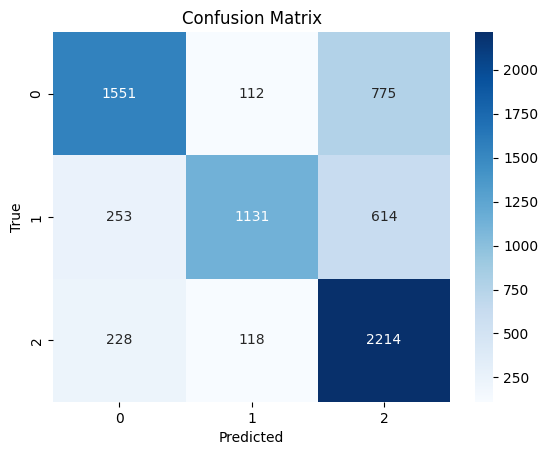

In [98]:
# confusion matrix for logreg
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred)

categories = [0, 1, 2]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories, yticklabels=categories)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

/var/folders/vw/gxx0mc0d2gd28913tn205f580000gn/T/ipykernel_17723/89699085.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')


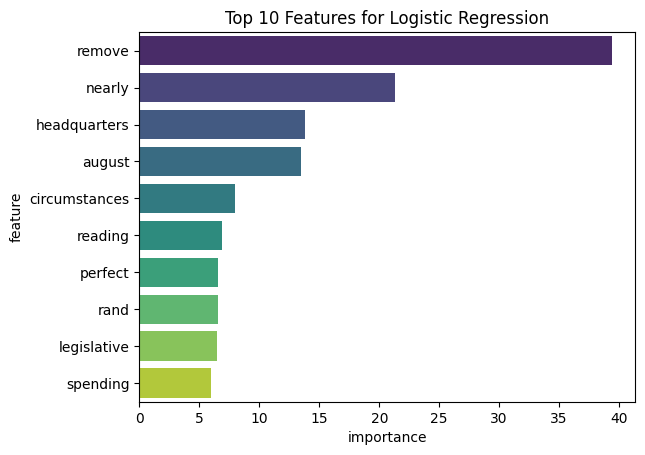

In [97]:
# feature importance for the best logreg model
coef = best_logreg.coef_[0]
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': coef})
top_features = feature_importance.sort_values(by='importance', ascending=False).head(10)

sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
plt.title('Top 10 Features for Logistic Regression')
plt.show()

In [ ]:
# error analysis for best logreg model
pd.set_option('display.max_colwidth', 200) 

wrong_pred = y_val[y_val != y_pred]
df_wrong_pred = df.loc[wrong_pred.index]

print(f"shape of error samples: {df_wrong_pred.shape}")
df_wrong_pred[['content_original', 'bias_text']].head()

shape of error samples: (2100, 15)


,content_original,bias_text
29281,"CLOSE Saudi Arabia and Iran will no longer be diplomatically tied after protesters, upset by a cleric's execution, set fire to the Saudi embassy in Tehran. Video provided by Newsy Newslook\n\nIran...",center
29283,"Donald Trump will release “very, very specific” results of a physical examination soon, the Republican presidential candidate said on Monday, a day after the Democratic nominee, Hillary Clinton, w...",left
29285,"Six women — so far — have declared their candidacies for the Democratic nomination in 2020. It’s the most women who’ve ever run for a major-party nomination in history.\n\nUntil this cycle, there ...",left
29290,"Let's not even go into the attacks on reproductive freedom or all the violence against women, or even the Aaron Sorkin characters who set your teeth on edge. Let's just talk about the ways pop cul...",left
29296,"Matt Wuerker Health-law opponents ready to party\n\nNo one knows what the Supreme Court is going to say about the health care law next week, but that hasn’t stopped the law’s opponents from planni...",left


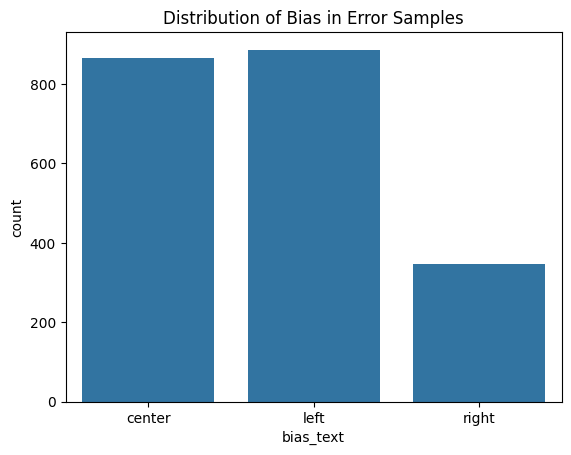

In [96]:
sns.countplot(x='bias_text', data=df_wrong_pred)
plt.title('Distribution of Bias in Error Samples')
plt.show()

We claim that logistic regression is a decent baseline, but recall that from the visualization, the relationship of news articles and their political bias isn’t that clear-cut, linear model methods may not capture the nonlinearity in our data. 

### Experimentation: Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier

estimators = [('rf', best_rf), ('logreg', best_logreg)]
stacking_clf = StackingClassifier(estimators=estimators, 
                                  final_estimator=LogisticRegression(random_state=42, n_jobs=-1, solver="saga", max_iter=1000), 
                                  n_jobs=-1)

stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=125,
                                                       min_samples_split=10,
                                                       n_estimators=1000,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('logreg',
                                LogisticRegression(C=1, max_iter=1000,
                                                   n_jobs=-1, penalty='l1',
                                                   random_state=42,
                                                   solver='saga'))],
                   final_estimator=LogisticRegression(max_iter=1000, n_jobs=-1,
                                                      random_state=42,
                                                      solver='saga'),
                   n_jobs=-1)

In [ ]:
# predict and evaluate
y_pred_stacking = stacking_clf.predict(X_val)
report_stacking = classification_report(y_val, y_pred_stacking, target_names=['left', 'center', 'right'])
print(report_stacking)

              precision    recall  f1-score   support

        left       0.74      0.71      0.73      2438
      center       0.74      0.70      0.72      1998
       right       0.70      0.77      0.73      2560

    accuracy                           0.73      6996
   macro avg       0.73      0.72      0.73      6996
weighted avg       0.73      0.73      0.73      6996



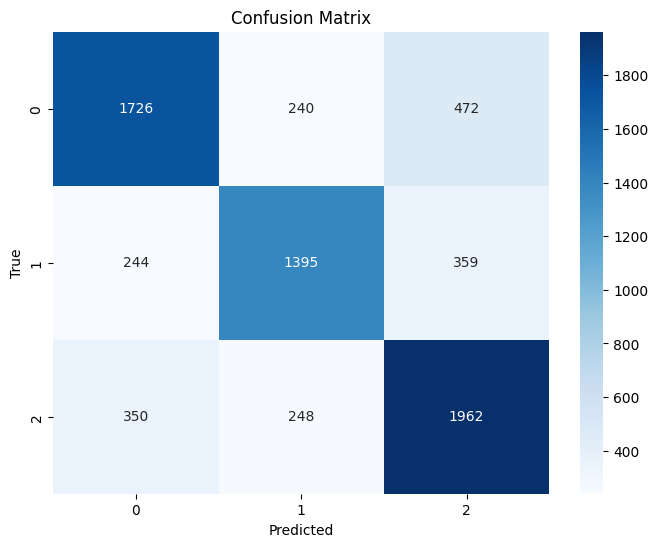

In [62]:
# confusion matrix for stacking
cm = confusion_matrix(y_val, y_pred_stacking)

categories = [0, 1, 2]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories, yticklabels=categories)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Experimentation: Logistic regression on embedded news articles

In [ ]:
# logistic regression on embedded features
embeddings = np.load('data/embeddings.npy')

In [ ]:
y = df['bias']

In [ ]:
train_mask = df['split'] == 'train'
test_mask = df['split'] == 'test'

# Split the embeddings and the outcome into training and testing sets
X_train = embeddings[train_mask]
X_test = embeddings[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42, solver='saga', max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='saga')

In [ ]:
# predict and evalaute
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['left', 'center', 'right'])
print(report)

              precision    recall  f1-score   support

        left       0.32      0.40      0.36       402
      center       0.20      0.04      0.06       299
       right       0.46      0.58      0.52       599

    accuracy                           0.40      1300
   macro avg       0.33      0.34      0.31      1300
weighted avg       0.36      0.40      0.36      1300



### Model Comparison

In [ ]:
# compare the performance of the best logreg, best rf, and stacking classifiers
label = ['left', 'center', 'right']

# best logreg
y_pred_logreg = best_logreg.predict(X_val)
report_logreg = classification_report(y_val, y_pred_logreg, target_names=label)

# best rf
y_pred_rf = best_rf.predict(X_val)
report_rf = classification_report(y_val, y_pred_rf, target_names=label)

# stacking
y_pred_stacking = stacking_clf.predict(X_val)
report_stacking = classification_report(y_val, y_pred_stacking, target_names=label)

In [ ]:
report_logreg = classification_report(y_val, y_pred_logreg, target_names=label, output_dict=True)
report_rf = classification_report(y_val, y_pred_rf, target_names=label, output_dict=True)
report_stacking = classification_report(y_val, y_pred_stacking, target_names=label, output_dict=True)

In [ ]:
def extract_metrics(report):
    """
    extracts criterion from the classification report.
    """
    accuracy = report['accuracy']
    precision = report["weighted avg"]["precision"]
    recall = report["weighted avg"]["recall"]
    f1_score = report["weighted avg"]["f1-score"]
    return [accuracy, precision, recall, f1_score]

In [ ]:
data = {
    "Logistic Regression": extract_metrics(report_logreg),
    "Random Forest": extract_metrics(report_rf),
    "Stacking": extract_metrics(report_stacking),
}
metrics = ['accuracy', 'precision', 'recall', 'f1-score']
df_metrics = pd.DataFrame(data, index=metrics).T
print(df_metrics)

                     accuracy  precision    recall  f1-score
Logistic Regression  0.689966   0.691275  0.689966  0.689817
Random Forest        0.699686   0.726528  0.699686  0.696970
Stacking             0.726558   0.727889  0.726558  0.726378


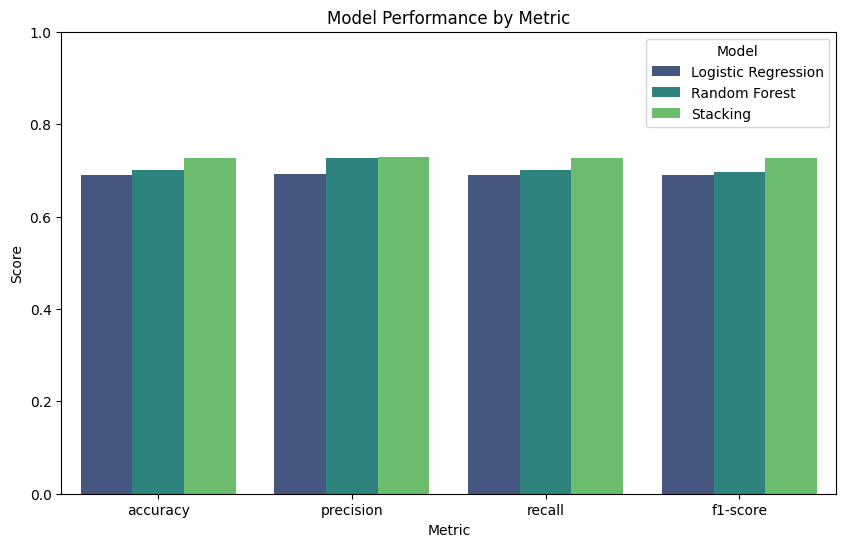

In [ ]:
df_long = df_metrics.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
df_long.rename(columns={'index': 'Model'}, inplace=True)

# Plot a grouped histogram chart
plt.figure(figsize=(10, 6))
sns.barplot(data=df_long, x='Metric', y='Score', hue='Model', palette='viridis')
plt.title("Model Performance Comparison")
plt.ylim(0, 1)
plt.show()